In [1]:
import numpy as np
from lmfit import Parameters, minimize, report_fit
from scipy.optimize import basinhopping, minimize as scipy_minimize
import matplotlib.pyplot as plt

# Define the Gaussian model function with a continuum
def gaussian_with_continuum(x, amp, cen, wid, cont):
    return -amp * np.exp(-(x - cen)**2 / (2 * wid**2)) + cont

# Define the double Gaussian model function with a continuum
def double_gaussian_with_continuum(x, amp1, cen1, wid1, amp2, cen2, wid2, cont):
    return (-amp1 * np.exp(-(x - cen1)**2 / (2*(wid1/2.355)**2)) -
            amp2 * np.exp(-(x - cen2)**2 / (2*(wid2/2.355)**2)) + cont)

# Define the individual Gaussian components with continuum
def gaussian_component(x, amp, cen, wid):
    return -amp * np.exp(-(x - cen)**2 / (2*(wid/2.355)**2))

In [2]:
# Data preparation
wavelengths = [
[4017.062037193338, 4017.262030324732, 4017.4620234561266, 4017.662016587521, 4017.862009718916, 4018.0620028503104, 4018.261995981705, 4018.4619891131006, 4018.661982244495, 4018.8619753758894, 4019.0619685072843, 4019.2619616386787, 4019.461954770073, 4019.6619479014685, 4019.861941032863, 4020.0619341642573, 4020.261927295652, 4020.4619204270466, 4020.661913558441, 4020.861906689836, 4021.061899821231, 4021.261892952625, 4021.4618860840205, 4021.661879215415, 4021.8618723468094, 4022.0618654782043, 4022.2618586095987, 4022.4618517409936, 4022.661844872388, 4022.861838003783, 4023.0618311351773, 4023.2618242665717, 4023.461817397967, 4023.6618105293614, 4023.8618036607563, 4024.061796792151, 4024.2617899235456, 4024.46178305494, 4024.661776186335, 4024.8617693177293, 4025.0617624491238, 4025.261755580519, 4025.4617487119135, 4025.661741843308, 4025.861734974703, 4026.0617281060972, 4026.2617212374917, 4026.461714368887, 4026.661707500282, 4026.8617006316763, 4027.061693763071, 4027.2616868944656, 4027.46168002586, 4027.6616731572544, 4027.8616662886493, 4028.061659420044, 4028.2616525514386, 4028.461645682834, 4028.6616388142284, 4028.861631945623, 4029.0616250770177, 4029.261618208412, 4029.461611339807, 4029.661604471202, 4029.8615976025962, 4030.0615907339907, 4030.2615838653855, 4030.46157699678, 4030.661570128175, 4030.8615632595697, 4031.061556390964, 4031.2615495223586, 4031.461542653754, 4031.6615357851483, 4031.8615289165427, 4032.061522047938, 4032.2615151793325, 4032.461508310727, 4032.6615014421213, 4032.861494573516, 4033.0614877049106, 4033.261480836305, 4033.461473967701, 4033.6614670990953, 4033.8614602304897, 4034.0614533618846, 4034.261446493279, 4034.4614396246734, 4034.6614327560683, 4034.861425887463, 4035.0614190188576, 4035.2614121502525, 4035.461405281647, 4035.6613984130413, 4035.861391544436, 4036.0613846758306, 4036.2613778072255, 4036.461370938621, 4036.661364070015, 4036.8613572014096, 4037.0613503328045, 4037.261343464199, 4037.4613365955934, 4037.6613297269882, 4037.861322858383, 4038.0613159897775, 4038.261309121172, 4038.4613022525673, 4038.6612953839617, 4038.861288515356, 4039.0612816467515, 4039.261274778146, 4039.4612679095403, 4039.661261040935, 4039.8612541723296, 4040.061247303724, 4040.2612404351194, 4040.461233566514, 4040.661226697908, 4040.861219829303, 4041.0612129606975, 4041.261206092092, 4041.4611992234873, 4041.661192354882, 4041.8611854862766, 4042.0611786176714, 4042.261171749066, 4042.4611648804603, 4042.6611580118547, 4042.8611511432496],
[4017.031123675372, 4017.2311152677084, 4017.431106860045, 4017.6310984523816, 4017.8310900447186, 4018.031081637055, 4018.2310732293918, 4018.431064821729, 4018.6310564140654, 4018.831048006402, 4019.031039598739, 4019.2310311910755, 4019.431022783412, 4019.631014375749, 4019.8310059680857, 4020.0309975604223, 4020.2309891527593, 4020.430980745096, 4020.6309723374325, 4020.8309639297695, 4021.0309555221056, 4021.230947114442, 4021.4309387067797, 4021.6309302991162, 4021.830921891453, 4022.03091348379, 4022.2309050761264, 4022.430896668463, 4022.6308882607996, 4022.8308798531366, 4023.030871445473, 4023.2308630378097, 4023.430854630147, 4023.6308462224833, 4023.83083781482, 4024.030829407157, 4024.2308209994935, 4024.43081259183, 4024.630804184167, 4024.8307957765037, 4025.0307873688403, 4025.2307789611773, 4025.430770553514, 4025.6307621458504, 4025.8307537381875, 4026.030745330524, 4026.23073692286, 4026.4307285151976, 4026.630720107534, 4026.830711699871, 4027.030703292208, 4027.2306948845444, 4027.430686476881, 4027.6306780692175, 4027.8306696615546, 4028.030661253891, 4028.2306528462277, 4028.430644438565, 4028.6306360309018, 4028.830627623238, 4029.030619215575, 4029.2306108079115, 4029.430602400248, 4029.630593992585, 4029.8305855849217, 4030.0305771772582, 4030.2305687695953, 4030.430560361932, 4030.6305519542684, 4030.8305435466054, 4031.030535138942, 4031.2305267312786, 4031.4305183236156, 4031.630509915952, 4031.8305015082888, 4032.030493100626, 4032.2304846929624, 4032.430476285299, 4032.6304678776355, 4032.8304594699725, 4033.030451062309, 4033.2304426546457, 4033.430434246983, 4033.6304258393197, 4033.8304174316563, 4034.0304090239933, 4034.2304006163295, 4034.430392208666, 4034.630383801003, 4034.8303753933396, 4035.030366985676, 4035.2303585780132, 4035.43035017035, 4035.6303417626864, 4035.8303333550234, 4036.03032494736, 4036.2303165396966, 4036.430308132034, 4036.6302997243706, 4036.8302913167067, 4037.0302829090438, 4037.2302745013803, 4037.430266093717, 4037.6302576860535, 4037.8302492783905, 4038.030240870727, 4038.2302324630637, 4038.430224055401, 4038.6302156477377, 4038.8302072400743, 4039.0301988324113, 4039.230190424748, 4039.430182017084, 4039.630173609421, 4039.8301652017576, 4040.030156794094, 4040.230148386431, 4040.430139978768, 4040.6301315711044, 4040.8301231634414, 4041.030114755778, 4041.2301063481145, 4041.430097940452, 4041.6300895327886, 4041.830081125125, 4042.0300727174617, 4042.2300643097983, 4042.430055902135, 4042.6300474944715, 4042.8300390868085],
[4017.0525146620735, 4017.25250731938, 4017.4524999766863, 4017.652492633993, 4017.8524852913, 4018.0524779486063, 4018.252470605913, 4018.4524632632206, 4018.652455920527, 4018.8524485778335, 4019.0524412351406, 4019.252433892447, 4019.4524265497535, 4019.65241920706, 4019.852411864367, 4020.0524045216735, 4020.25239717898, 4020.452389836287, 4020.6523824935934, 4020.8523751509, 4021.052367808207, 4021.2523604655134, 4021.4523531228206, 4021.6523457801272, 4021.852338437434, 4022.0523310947406, 4022.2523237520472, 4022.4523164093534, 4022.65230906666, 4022.8523017239672, 4023.0522943812734, 4023.25228703858, 4023.4522796958877, 4023.652272353194, 4023.8522650105006, 4024.0522576678077, 4024.252250325114, 4024.4522429824206, 4024.6522356397277, 4024.852228297034, 4025.0522209543406, 4025.252213611647, 4025.452206268954, 4025.6521989262606, 4025.852191583567, 4026.052184240874, 4026.2521768981806, 4026.4521695554877, 4026.6521622127943, 4026.852154870101, 4027.0521475274077, 4027.2521401847143, 4027.452132842021, 4027.652125499327, 4027.8521181566343, 4028.0521108139405, 4028.252103471247, 4028.452096128555, 4028.652088785861, 4028.8520814431677, 4029.052074100475, 4029.252066757781, 4029.4520594150877, 4029.652052072395, 4029.852044729701, 4030.0520373870077, 4030.252030044315, 4030.452022701621, 4030.6520153589277, 4030.8520080162343, 4031.052000673541, 4031.2519933308477, 4031.451985988155, 4031.6519786454614, 4031.851971302768, 4032.0519639600748, 4032.2519566173814, 4032.451949274688, 4032.6519419319943, 4032.8519345893014, 4033.0519272466076, 4033.2519199039143, 4033.451912561222, 4033.651905218528, 4033.8518978758348, 4034.051890533142, 4034.251883190448, 4034.4518758477548, 4034.651868505062, 4034.851861162368, 4035.0518538196748, 4035.251846476982, 4035.451839134288, 4035.6518317915948, 4035.8518244489014, 4036.051817106208, 4036.2518097635148, 4036.451802420822, 4036.6517950781285, 4036.851787735435, 4037.051780392742, 4037.2517730500485, 4037.451765707355, 4037.6517583646614, 4037.8517510219685, 4038.051743679275, 4038.2517363365814, 4038.451728993889, 4038.651721651195, 4038.851714308502, 4039.051706965809, 4039.251699623115, 4039.451692280422, 4039.651684937729, 4039.851677595035, 4040.051670252342, 4040.251662909649, 4040.451655566955, 4040.651648224262, 4040.851640881569, 4041.051633538875, 4041.251626196182, 4041.451618853489, 4041.6516115107956, 4041.8516041681023, 4042.051596825409, 4042.2515894827156, 4042.4515821400223, 4042.6515747973285, 4042.8515674546356],
[4017.060093856534, 4017.2600868911777, 4017.4600799258214, 4017.6600729604647, 4017.860065995109, 4018.0600590297527, 4018.2600520643964, 4018.460045099041, 4018.660038133685, 4018.8600311683285, 4019.0600242029723, 4019.260017237616, 4019.4600102722598, 4019.660003306904, 4019.8599963415477, 4020.0599893761914, 4020.2599824108356, 4020.4599754454794, 4020.6599684801226, 4020.859961514767, 4021.0599545494106, 4021.2599475840543, 4021.459940618699, 4021.6599336533427, 4021.8599266879864, 4022.05991972263, 4022.259912757274, 4022.4599057919177, 4022.6598988265614, 4022.8598918612056, 4023.0598848958493, 4023.259877930493, 4023.4598709651373, 4023.659863999781, 4023.8598570344247, 4024.059850069069, 4024.2598431037127, 4024.4598361383564, 4024.6598291730006, 4024.859822207644, 4025.0598152422876, 4025.259808276932, 4025.4598013115756, 4025.6597943462193, 4025.8597873808635, 4026.0597804155072, 4026.2597734501505, 4026.459766484795, 4026.659759519439, 4026.8597525540827, 4027.059745588727, 4027.2597386233706, 4027.4597316580143, 4027.6597246926576, 4027.859717727302, 4028.0597107619456, 4028.2597037965893, 4028.459696831234, 4028.6596898658777, 4028.8596829005214, 4029.0596759351656, 4029.259668969809, 4029.4596620044526, 4029.659655039097, 4029.8596480737406, 4030.0596411083843, 4030.2596341430285, 4030.4596271776722, 4030.6596202123155, 4030.8596132469597, 4031.0596062816035, 4031.259599316247, 4031.459592350892, 4031.6595853855356, 4031.8595784201793, 4032.059571454823, 4032.259564489467, 4032.4595575241106, 4032.6595505587543, 4032.8595435933985, 4033.059536628042, 4033.259529662686, 4033.45952269733, 4033.659515731974, 4033.8595087666176, 4034.059501801262, 4034.2594948359056, 4034.4594878705493, 4034.6594809051935, 4034.859473939837, 4035.0594669744805, 4035.2594600091247, 4035.4594530437685, 4035.659446078412, 4035.8594391130564, 4036.0594321477, 4036.2594251823434, 4036.459418216988, 4036.659411251632, 4036.8594042862755, 4037.0593973209197, 4037.2593903555635, 4037.459383390207, 4037.659376424851, 4037.8593694594947, 4038.0593624941384, 4038.259355528782, 4038.459348563427, 4038.6593415980706, 4038.8593346327143, 4039.0593276673585, 4039.259320702002, 4039.4593137366455, 4039.6593067712897, 4039.8592998059335, 4040.059292840577, 4040.2592858752214, 4040.459278909865, 4040.6592719445084, 4040.8592649791526, 4041.0592580137964, 4041.25925104844, 4041.4592440830847, 4041.6592371177285, 4041.859230152372, 4042.059223187016, 4042.2592162216597, 4042.4592092563034, 4042.659202290947, 4042.8591953255914],
[4017.0299891243703, 4017.2299806602223, 4017.4299721960742, 4017.629963731926, 4017.829955267778, 4018.02994680363, 4018.229938339482, 4018.429929875335, 4018.629921411187, 4018.829912947039, 4019.0299044828907, 4019.2298960187427, 4019.4298875545946, 4019.629879090447, 4019.829870626299, 4020.029862162151, 4020.229853698003, 4020.429845233855, 4020.629836769707, 4020.829828305559, 4021.029819841411, 4021.2298113772626, 4021.4298029131155, 4021.6297944489675, 4021.8297859848194, 4022.029777520672, 4022.2297690565238, 4022.4297605923753, 4022.629752128227, 4022.8297436640796, 4023.0297351999316, 4023.2297267357835, 4023.4297182716364, 4023.629709807488, 4023.82970134334, 4024.029692879192, 4024.229684415044, 4024.429675950896, 4024.6296674867485, 4024.8296590226, 4025.029650558452, 4025.2296420943044, 4025.4296336301563, 4025.6296251660083, 4025.8296167018607, 4026.029608237712, 4026.229599773564, 4026.429591309417, 4026.629582845269, 4026.829574381121, 4027.0295659169733, 4027.229557452825, 4027.4295489886767, 4027.6295405245287, 4027.829532060381, 4028.029523596233, 4028.229515132085, 4028.4295066679374, 4028.6294982037894, 4028.8294897396413, 4029.0294812754937, 4029.2294728113457, 4029.4294643471976, 4029.6294558830496, 4029.8294474189015, 4030.0294389547535, 4030.229430490606, 4030.429422026458, 4030.6294135623093, 4030.8294050981617, 4031.0293966340137, 4031.2293881698656, 4031.4293797057185, 4031.6293712415704, 4031.829362777422, 4032.0293543132743, 4032.2293458491263, 4032.429337384978, 4032.62932892083, 4032.8293204566826, 4033.029311992534, 4033.229303528386, 4033.429295064239, 4033.629286600091, 4033.829278135943, 4034.029269671795, 4034.2292612076467, 4034.4292527434986, 4034.629244279351, 4034.829235815203, 4035.029227351055, 4035.2292188869073, 4035.429210422759, 4035.629201958611, 4035.829193494463, 4036.029185030315, 4036.229176566167, 4036.42916810202, 4036.6291596378715, 4036.8291511737234, 4037.029142709576, 4037.2291342454278, 4037.4291257812797, 4037.6291173171317, 4037.8291088529836, 4038.0291003888356, 4038.2290919246875, 4038.4290834605404, 4038.6290749963923, 4038.8290665322443, 4039.029058068096, 4039.229049603948, 4039.4290411398, 4039.6290326756525, 4039.8290242115045, 4040.029015747356, 4040.2290072832084, 4040.4289988190603, 4040.6289903549123, 4040.8289818907647, 4041.0289734266166, 4041.228964962468, 4041.428956498321, 4041.628948034173, 4041.828939570025, 4042.0289311058773, 4042.2289226417292, 4042.4289141775807, 4042.6289057134327, 4042.828897249285]
]

fluxes = [
[1.0365711, 0.9768954, 0.98638314, 1.001783, 1.0047108, 1.0204816, 0.9795359, 0.95766217, 1.0053893, 1.0390307, 0.9932781, 1.0384886, 1.045276, 1.0022849, 1.0140483, 0.93227553, 1.0012269, 0.9763614, 1.0202705, 1.03607, 1.0308069, 1.0210824, 1.0076542, 1.0229312, 1.0374628, 1.0219605, 1.0179822, 1.031191, 1.0218502, 0.995002, 1.066809, 1.0149295, 1.08358, 0.9680812, 1.0192014, 0.95528525, 1.0120476, 0.9807692, 0.98886704, 0.98853487, 0.9480535, 1.0062481, 0.9423176, 0.96405756, 0.92859215, 0.97659135, 0.88732123, 0.8626976, 0.9183166, 0.8441385, 0.8239039, 0.82816553, 0.7657798, 0.80787337, 0.7541934, 0.7990375, 0.7505147, 0.7548348, 0.76056933, 0.77855223, 0.7613986, 0.77160466, 0.81129915, 0.8181417, 0.86761385, 0.8726302, 0.902131, 0.92498714, 0.9101526, 0.92961895, 0.9897279, 0.9506742, 0.95321476, 0.99821776, 1.0178407, 0.9933658, 1.0396487, 1.032047, 1.0306785, 1.0592979, 1.019957, 0.9561388, 1.0488002, 0.9985422, 0.95584714, 1.0275805, 1.0300206, 0.9729931, 1.0580631, 0.988706, 1.0029925, 1.0097492, 0.9788001, 1.0123173, 0.9877799, 1.0125675, 1.0637815, 1.0650324, 0.9977725, 1.0129892, 1.0451808, 1.0042682, 1.0176269, 0.9876863, 1.0313834, 1.0459179, 1.0226116, 1.0267103, 0.94959825, 0.9740749, 0.9902298, 1.0591068, 1.0074713, 1.0391608, 1.0276724, 0.9833921, 1.0175946, 0.9857064, 1.0431888, 1.0171081, 1.0356139, 1.0114903, 1.0019301, 1.0173764, 1.00125, 1.0334258, 1.0288585, 1.0063682, 1.0249637, 0.99701786],
[0.97011775, 1.0305183, 1.032309, 0.9867761, 0.9811406, 0.985959, 0.98548377, 1.0515476, 1.0349228, 1.0571538, 1.013771, 1.0451639, 1.0173583, 1.0281571, 1.0292904, 1.0396109, 1.0148294, 1.0105776, 1.0588888, 1.0496107, 1.019716, 1.0337692, 1.0158151, 1.0192244, 1.0500853, 1.0435739, 0.9974787, 0.98274976, 1.012843, 0.9830342, 1.0412837, 1.0122912, 0.949481, 1.0012771, 0.9677644, 0.9410719, 1.0194453, 0.9328845, 0.93537754, 0.9269576, 0.9272389, 0.9035089, 0.95555866, 0.91638815, 0.91071737, 0.9240134, 0.9157084, 0.96245134, 0.9281526, 0.9701013, 1.000895, 0.9718367, 0.9152908, 0.91405016, 0.95897883, 1.0036516, 0.95582086, 0.94139004, 0.9419555, 0.9799846, 0.92144483, 0.8980317, 0.89621174, 0.88571614, 0.8844947, 0.83739245, 0.8331504, 0.8192727, 0.85233474, 0.80918145, 0.83357334, 0.8524969, 0.8576101, 0.853852, 0.8922781, 0.88796747, 0.9002296, 0.9079178, 0.9229068, 0.9711517, 0.9684656, 0.9596181, 0.985619, 0.98558766, 1.001291, 0.9960128, 0.98295647, 0.9703761, 1.0535048, 0.9720864, 1.0302843, 1.0475457, 0.99570626, 0.98744464, 1.0103327, 1.0120775, 1.042057, 1.0398167, 0.9992239, 0.98293567, 1.0431694, 0.96530885, 0.97575206, 1.0093975, 1.010389, 1.0049753, 1.0220374, 1.0003477, 1.0415512, 1.0035727, 1.0636072, 1.0389409, 1.0203192, 1.0021188, 0.9703461, 0.99113125, 1.0194697, 0.99659586, 0.9713872, 0.97621083, 0.9706113, 1.0278566, 1.0135558, 0.9707083, 1.0404419, 0.99301994, 0.97377247, 1.0451472, 1.058964, 1.0139333],
[0.95530343, 1.0020808, 1.0469904, 1.0396913, 1.025194, 1.0700486, 1.0237552, 1.0383129, 0.9811945, 1.0632024, 0.98848796, 1.0206715, 1.025023, 0.98188174, 1.0376012, 1.0353575, 1.0075251, 1.0212331, 1.0248553, 1.0015751, 1.0057902, 1.0163251, 1.0287212, 0.97194964, 0.9897062, 1.0035253, 0.97681075, 0.9729947, 0.98854864, 0.9710496, 1.0165315, 0.9764483, 1.0161413, 0.9706739, 0.972617, 0.9690871, 0.9699416, 0.8871392, 0.913515, 0.95802766, 0.9571625, 0.9156809, 0.9093651, 0.86046803, 0.8026198, 0.8411327, 0.84465116, 0.7796615, 0.81914407, 0.8366865, 0.8516987, 0.8366314, 0.82412505, 0.85082674, 0.84197104, 0.84977084, 0.88429934, 0.9447425, 0.9669197, 0.9520885, 0.9234005, 0.9178586, 0.91373366, 0.8880646, 0.8806101, 0.88246053, 0.9046563, 0.94274354, 0.9238107, 0.93796647, 0.93765366, 0.90566826, 0.9416052, 0.95071113, 0.9376853, 0.9408436, 1.0066495, 1.0274764, 0.9681071, 0.9840492, 0.9883867, 0.98149246, 1.0076009, 1.0188286, 1.0100697, 1.0632002, 0.9941461, 1.000036, 1.0433987, 1.0150914, 1.0182315, 0.9424984, 1.0625135, 0.9585225, 0.9794065, 1.0077395, 0.9879925, 1.0136784, 1.0271329, 1.0254494, 1.0125592, 0.9900873, 1.0216737, 1.0024389, 1.0324026, 1.0183542, 1.0208915, 1.0687866, 1.032029, 0.9864168, 1.00522, 1.0266457, 1.01028, 1.0131234, 1.0126264, 1.0419556, 1.0153245, 1.0435573, 1.0419601, 1.0080413, 0.9924771, 0.97125345, 1.0194556, 1.0282047, 1.025353, 0.9672464, 1.0042803, 0.97416687, 1.0053865, 0.97449285],
[1.026424, 1.1392804, 1.0176027, 0.92712104, 0.9848659, 1.0292405, 1.0297757, 0.98180866, 1.00972, 1.0240983, 1.0750796, 1.0699902, 1.0693805, 1.0534731, 1.0375769, 1.0543935, 1.0149837, 0.98250043, 1.0164622, 1.0639033, 1.0587802, 0.9992037, 1.0577267, 1.0651157, 1.0177882, 1.0792288, 1.0176198, 1.0512284, 1.0205203, 0.9655673, 0.9630565, 1.0223382, 0.99315935, 1.000291, 1.0202674, 0.92717254, 0.91533357, 0.9586661, 1.0355749, 0.9680057, 0.92301476, 1.0213778, 0.95556074, 0.9821869, 0.8426362, 0.94450974, 0.84882003, 0.87861663, 0.7547542, 0.8294706, 0.83856106, 0.94214535, 0.9425041, 0.84850156, 0.882601, 0.8830405, 0.89564747, 0.88663256, 0.84998715, 0.898139, 0.9680941, 0.8679872, 0.9145096, 0.92210597, 0.8117006, 0.9109672, 0.8481284, 0.98784214, 0.9362053, 0.9586364, 0.97689295, 0.9475865, 0.883123, 0.94015265, 0.97941107, 0.94383854, 1.0004884, 1.0039219, 0.9313635, 0.9923585, 0.96628845, 1.0126202, 1.0113131, 1.0385442, 1.091165, 1.0064355, 1.0612043, 0.98327893, 1.0426421, 1.0689384, 0.965017, 0.974335, 1.0852014, 1.0845002, 1.0988073, 1.0481683, 1.0230733, 1.0471505, 1.0583085, 0.9824952, 1.0603001, 0.9984797, 0.9728503, 1.0726761, 1.0096534, 1.097258, 1.0836276, 1.021318, 1.0844324, 1.1472623, 1.0950618, 1.020356, 1.0434496, 1.0464745, 1.1115543, 0.99858075, 0.96518815, 1.0126077, 0.91829616, 1.057891, 1.0552108, 0.9818161, 0.9945642, 0.99403554, 0.966893, 1.0169847, 0.95671093, 1.0275836, 0.9969526, 0.9463117],
[1.0053939, 0.9699029, 1.0008448, 1.0061666, 0.9852719, 1.043723, 1.0558555, 1.0269719, 0.99038607, 1.018488, 1.010574, 1.0391306, 1.0018638, 1.0233217, 1.0409865, 1.0320332, 1.0151329, 1.0215657, 1.0610503, 1.0336599, 1.0370654, 0.9810114, 1.0417558, 1.0274202, 1.0286332, 1.0062119, 1.00518, 1.0396911, 0.9938716, 1.0033634, 1.0078957, 0.99539584, 0.99231684, 1.0598829, 0.9597232, 0.9686972, 0.9665276, 1.0444437, 0.97765213, 1.0018717, 0.98026806, 0.9848836, 0.96423835, 0.9833444, 0.9586694, 0.9635007, 0.94042075, 0.88200986, 0.897695, 0.8561885, 0.8570953, 0.8699853, 0.80102223, 0.79689157, 0.80810213, 0.7760512, 0.77406985, 0.799909, 0.78259706, 0.7577657, 0.7970236, 0.7826806, 0.75979555, 0.8050847, 0.8478229, 0.8681931, 0.8349736, 0.8642883, 0.9004191, 0.92118335, 1.0050763, 0.9992571, 0.97660774, 0.9402248, 1.0010667, 1.0043321, 1.0052642, 1.040995, 1.0278955, 0.97680384, 0.9880213, 1.0002406, 0.98094547, 0.9863615, 0.99373597, 0.9647836, 0.99555117, 0.9975856, 0.9780219, 1.0192041, 1.027393, 0.9907604, 0.97567254, 0.9914972, 1.0385785, 1.0460367, 1.0372077, 0.9503998, 1.0109466, 1.0033596, 1.061107, 1.0365574, 1.014221, 1.0390404, 1.024896, 1.0399278, 1.0325663, 1.032078, 0.9817865, 1.0223548, 0.98910743, 1.0184752, 1.0263975, 1.0068758, 0.9639284, 1.0269496, 1.0094719, 1.0096223, 0.994668, 1.0220337, 0.98077106, 0.9692075, 0.9778751, 1.0287042, 1.0164129, 0.98450214, 1.0091518, 1.0184892, 1.05225, 0.9762847]
]

Initial parameter values:
amp1: 0.2 (type: <class 'float'>)
wid1: 3.0 (type: <class 'float'>)
amp2: 0.12 (type: <class 'float'>)
wid2: 3.0 (type: <class 'float'>)
cont: 1.0 (type: <class 'float'>)
cen1_1: 4027 (type: <class 'int'>)
offset_1: 4 (type: <class 'int'>)
cen2_1: 4031 (type: <class 'int'>)
cen1_2: 4027 (type: <class 'int'>)
offset_2: 4 (type: <class 'int'>)
cen2_2: 4031 (type: <class 'int'>)
cen1_3: 4027 (type: <class 'int'>)
offset_3: 4 (type: <class 'int'>)
cen2_3: 4031 (type: <class 'int'>)
cen1_4: 4027 (type: <class 'int'>)
offset_4: 4 (type: <class 'int'>)
cen2_4: 4031 (type: <class 'int'>)


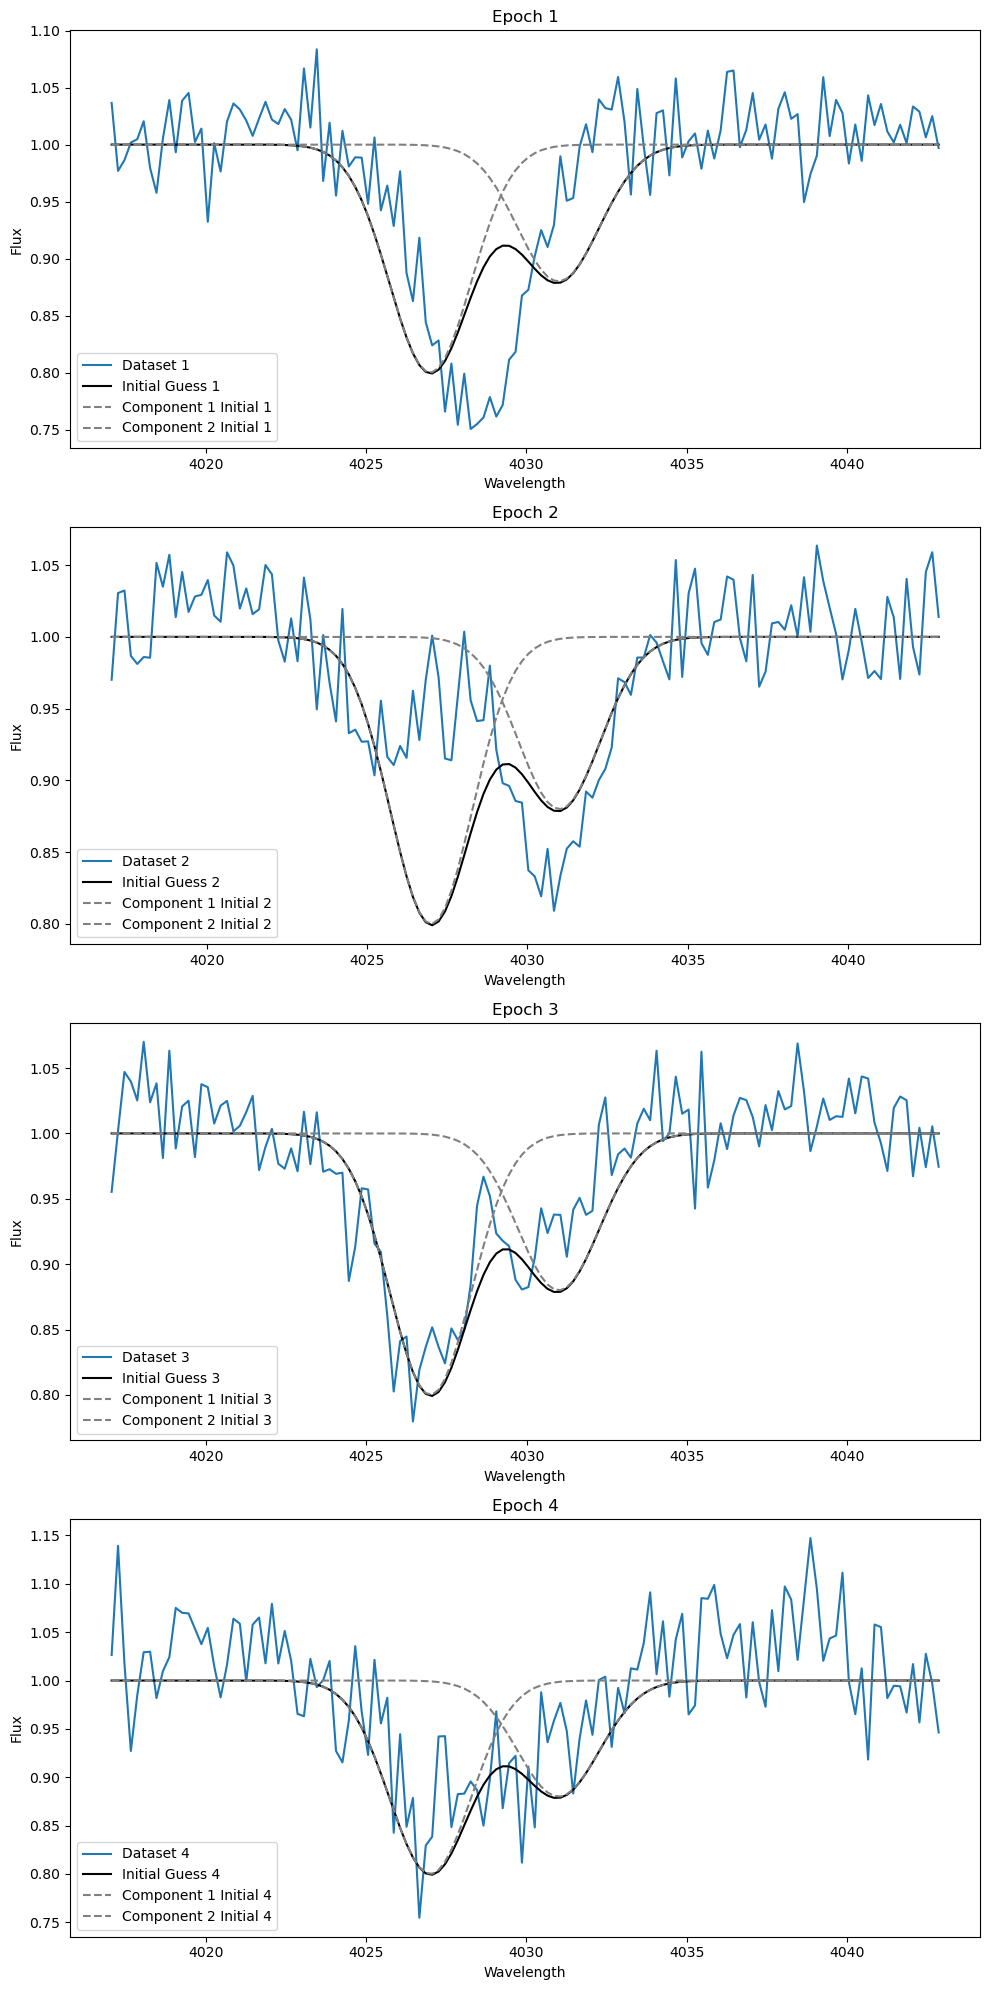

[[Variables]]
    amp1:      0.11031036 (init = 0.1103104)
    wid1:      2.59451797 (init = 2.594518)
    amp2:      0.14298997 (init = 0.14299)
    wid2:      4.57866018 (init = 4.57866)
    cont:      1.01734928 (init = 1.017349)
    cen1_1:    4028.53075 (init = 4028.531)
    offset_1:  4.00000000 (init = 4)
    cen2_1:    4028.206 (fixed)
    cen1_2:    4025.37987 (init = 4025.38)
    offset_2:  4.00000000 (init = 4)
    cen2_2:    4030.713 (fixed)
    cen1_3:    4025.97445 (init = 4025.974)
    offset_3:  4.00000000 (init = 4)
    cen2_3:    4028.601 (fixed)
    cen1_4:    4026.31942 (init = 4026.319)
    offset_4:  4.00000000 (init = 4)
    cen2_4:    4029.335 (fixed)


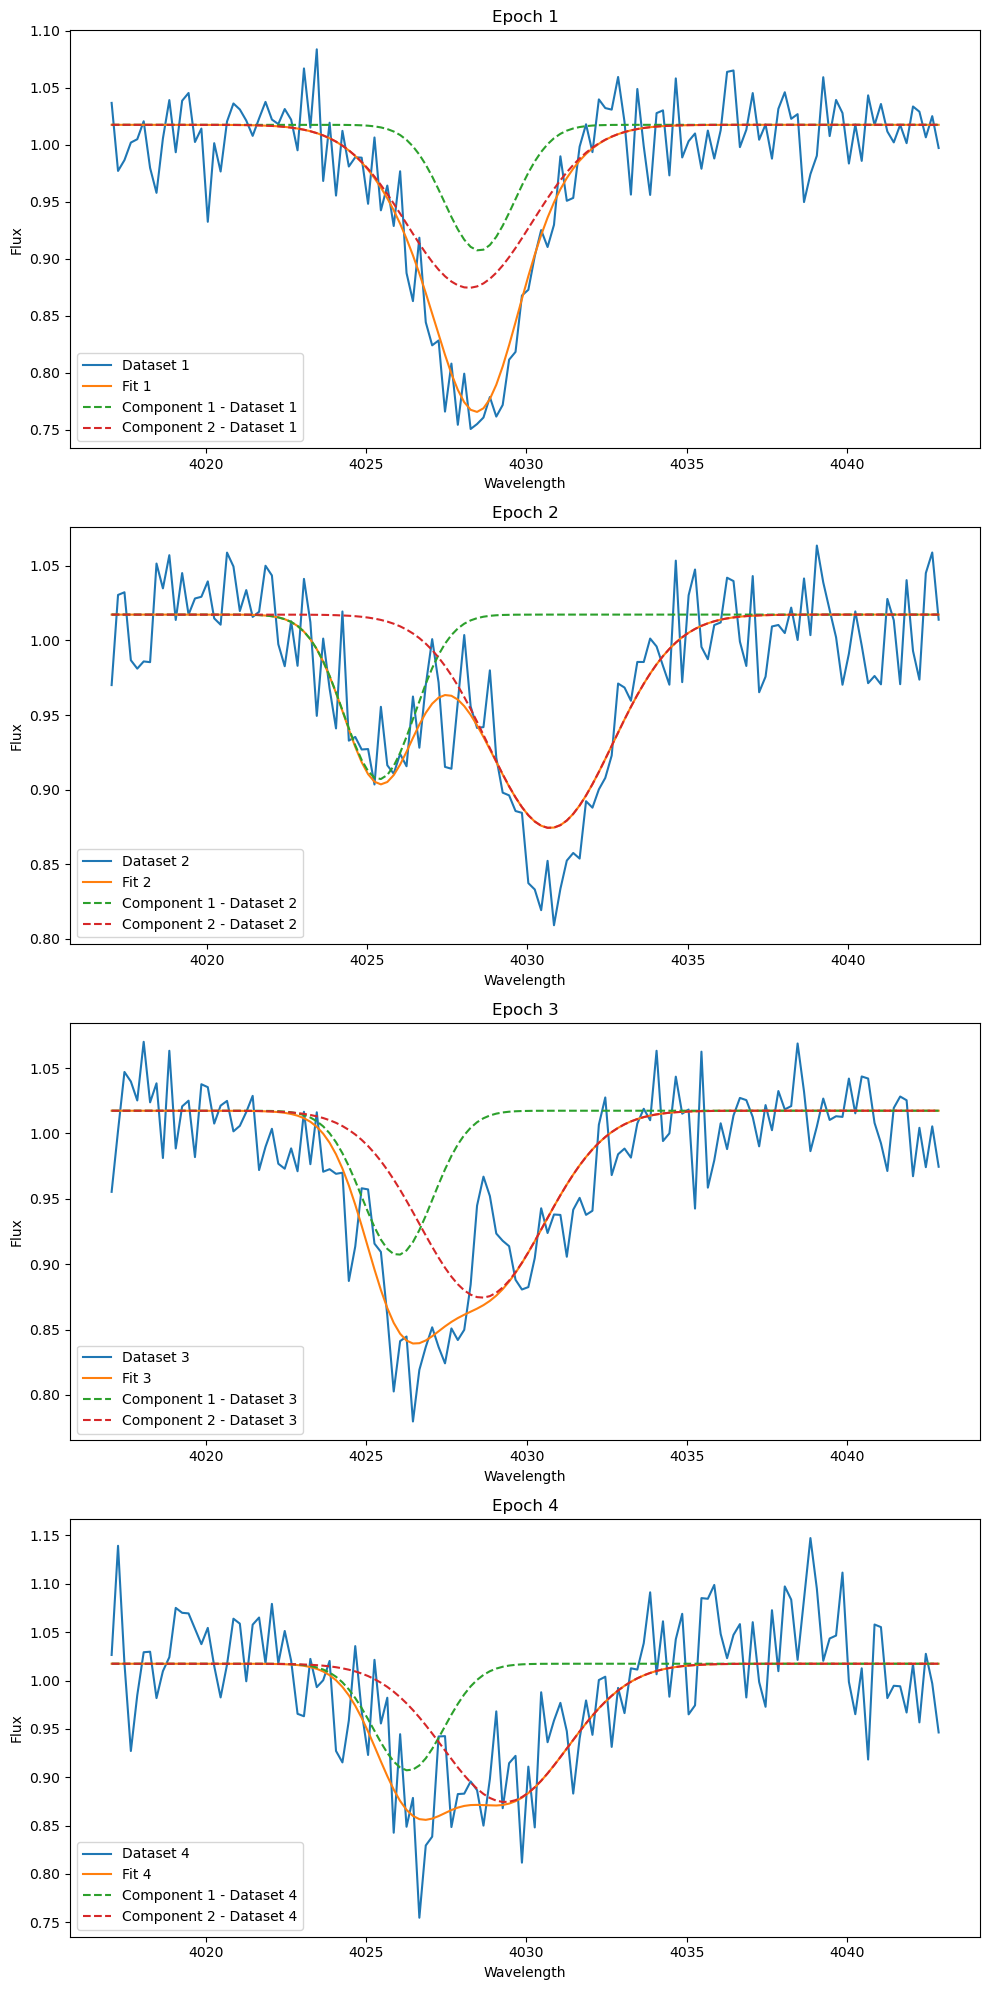

In [9]:
# Define the maximum separation allowed between cen1 and cen2
max_separation = 20  # Adjust this value as needed

# Define parameters for the model
params = Parameters()
params.add('amp1', value=0.2, min=0.05, max=1)
params.add('wid1', value=3.0, min=0.5, max=10.0)
params.add('amp2', value=0.12, min=0.05, max=1)
params.add('wid2', value=3.0, min=0.5, max=10.0)
params.add('cont', value=1.0, min=0.9, max=1.1)

# Add parameters for the centers of the two Gaussians for each epoch
for i in range(len(wavelengths)):
    params.add(f'cen1_{i+1}', value=4027, min=4015, max=4035)
    params.add(f'offset_{i+1}', value=4, min=-max_separation, max=max_separation)
    params.add(f'cen2_{i+1}', expr=f'cen1_{i+1} + offset_{i+1}')

# Print initial parameter values for debugging
print("Initial parameter values:")
for name, param in params.items():
    print(f"{name}: {param.value} (type: {type(param.value)})")
# print(params['amp1'].value, cen1, params['wid1'].value)

# Plot initial guesses
fig, axes = plt.subplots(nrows=len(wavelengths), ncols=1, figsize=(10, 5*len(wavelengths)))
for i, (x_vals, data_vals) in enumerate(zip(wavelengths, fluxes)):
    ax = axes[i]
    ax.plot(x_vals, data_vals, '-', label=f'Dataset {i+1}')
    cen1 = params[f'cen1_{i+1}'].value
    cen2 = params[f'cen2_{i+1}'].value
    component1_initial = gaussian_component(x_vals, params['amp1'].value, np.float64(cen1), params['wid1'].value)
    component2_initial = gaussian_component(x_vals, params['amp2'].value, np.float64(cen2), params['wid2'].value)
    initial_guess = component1_initial + component2_initial + params['cont'].value
    ax.plot(x_vals, initial_guess, 'k-', label=f'Initial Guess {i+1}')
    ax.plot(x_vals, component1_initial + params['cont'].value, '--', c='grey', label=f'Component 1 Initial {i+1}')
    ax.plot(x_vals, component2_initial + params['cont'].value, '--', c='grey', label=f'Component 2 Initial {i+1}')
    ax.legend()
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Flux')
    ax.set_title(f'Epoch {i+1}')
plt.tight_layout()
plt.show()

# Objective function that calculates the residual of all datasets
def objective(params, x, data):
    resid = []
    for i, (x_vals, data_vals) in enumerate(zip(x, data)):
        cen1 = np.float64(params[f'cen1_{i+1}'].value)
        cen2 = np.float64(params[f'cen2_{i+1}'].value)
        model = double_gaussian_with_continuum(x_vals, np.float64(params['amp1'].value), cen1, np.float64(params['wid1'].value), 
                                               np.float64(params['amp2'].value), cen2, np.float64(params['wid2'].value), np.float64(params['cont'].value))
        resid.append(data_vals - model)
    return np.concatenate(resid)

# Function to convert lmfit Parameters to a flat array
def params_to_array(params):
    return np.array([param.value for param in params.values()], dtype=np.float64)

# Function to convert a flat array back to lmfit Parameters
def array_to_params(param_array, params):
    for i, (name, param) in enumerate(params.items()):
        param.set(value=np.float64(param_array[i]))

# Wrapper function for the objective to use with scipy.optimize
def objective_wrapper(param_array, x, data, params):
    array_to_params(param_array, params)
    return np.sum(objective(params, x, data)**2)  # Return the sum of squares of the residuals

# Initial parameter array
initial_params = params_to_array(params)

# Perform the global optimization with Basin Hopping
minimizer_kwargs = {"method": "L-BFGS-B", "args": (wavelengths, fluxes, params)}
result = basinhopping(objective_wrapper, initial_params, minimizer_kwargs=minimizer_kwargs, niter=100)

# Update lmfit Parameters with the optimized values
array_to_params(result.x, params)

# Print fit results
report_fit(params)

# Plot results with subplots
fig, axes = plt.subplots(nrows=len(wavelengths), ncols=1, figsize=(10, 5*len(wavelengths)))

for i, (x_vals, data_vals) in enumerate(zip(wavelengths, fluxes)):
    ax = axes[i]
    ax.plot(x_vals, data_vals, '-', label=f'Dataset {i+1}')
    model_fit = double_gaussian_with_continuum(x_vals, params['amp1'].value, params[f'cen1_{i+1}'].value, params['wid1'].value, 
                                               params['amp2'].value, params[f'cen2_{i+1}'].value, params['wid2'].value, params['cont'].value)
    component1 = gaussian_component(x_vals, params['amp1'].value, params[f'cen1_{i+1}'].value, params['wid1'].value)
    component2 = gaussian_component(x_vals, params['amp2'].value, params[f'cen2_{i+1}'].value, params['wid2'].value)
    
    ax.plot(x_vals, model_fit, '-', label=f'Fit {i+1}')
    ax.plot(x_vals, component1 + params['cont'].value, '--', label=f'Component 1 - Dataset {i+1}')
    ax.plot(x_vals, component2 + params['cont'].value, '--', label=f'Component 2 - Dataset {i+1}')
    ax.legend()
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Flux')
    ax.set_title(f'Epoch {i+1}')

plt.tight_layout()
plt.show()

In [57]:
0.19184372/0.05000000

3.8368743999999997

In [58]:
0.05000000/0.19184372

0.2606288076565655

In [ ]:
# Objective function that calculates the residual of all datasets
def objective(params, x, data):
    resid = []
    for i, (x_vals, data_vals) in enumerate(zip(x, data)):
        cen1 = params[f'cen1_{i+1}']
        cen2 = params[f'cen2_{i+1}']
        model = double_gaussian_with_continuum(x_vals, params['amp1'], cen1, params['wid1'], 
                                               params['amp2'], cen2, params['wid2'], params['cont'])
        resid.append(data_vals - model)
    return np.concatenate(resid)



# Perform the fit
result = minimize(objective, params, args=(wavelengths, fluxes))
# Print fit results
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 129
    # data points      = 650
    # variables        = 15
    chi-square         = 0.70246844
    reduced chi-square = 0.00110625
    Akaike info crit   = -4409.58266
    Bayesian info crit = -4342.42807
[[Variables]]
    amp1:    0.11066748 +/- 0.00733084 (6.62%) (init = 0.1105616)
    wid1:    2.67028322 +/- 0.19604983 (7.34%) (init = 2.670419)
    amp2:    0.14309910 +/- 0.00588703 (4.11%) (init = 0.1431224)
    wid2:    4.49428837 +/- 0.20730045 (4.61%) (init = 4.495475)
    cont:    1.01634784 +/- 0.00169686 (0.17%) (init = 1.016346)
    cen1_1:  4028.54130 +/- 0.25918056 (0.01%) (init = 4028.54)
    cen2_1:  4028.19796 +/- 0.25956920 (0.01%) (init = 4028.201)
    cen1_2:  4025.39705 +/- 0.16093920 (0.00%) (init = 4025.399)
    cen2_2:  4030.72371 +/- 0.16149443 (0.00%) (init = 4030.722)
    cen1_3:  4025.95577 +/- 0.16411582 (0.00%) (init = 4025.954)
    cen2_3:  4028.62582 +/- 0.17848656 (0.00%) (ini

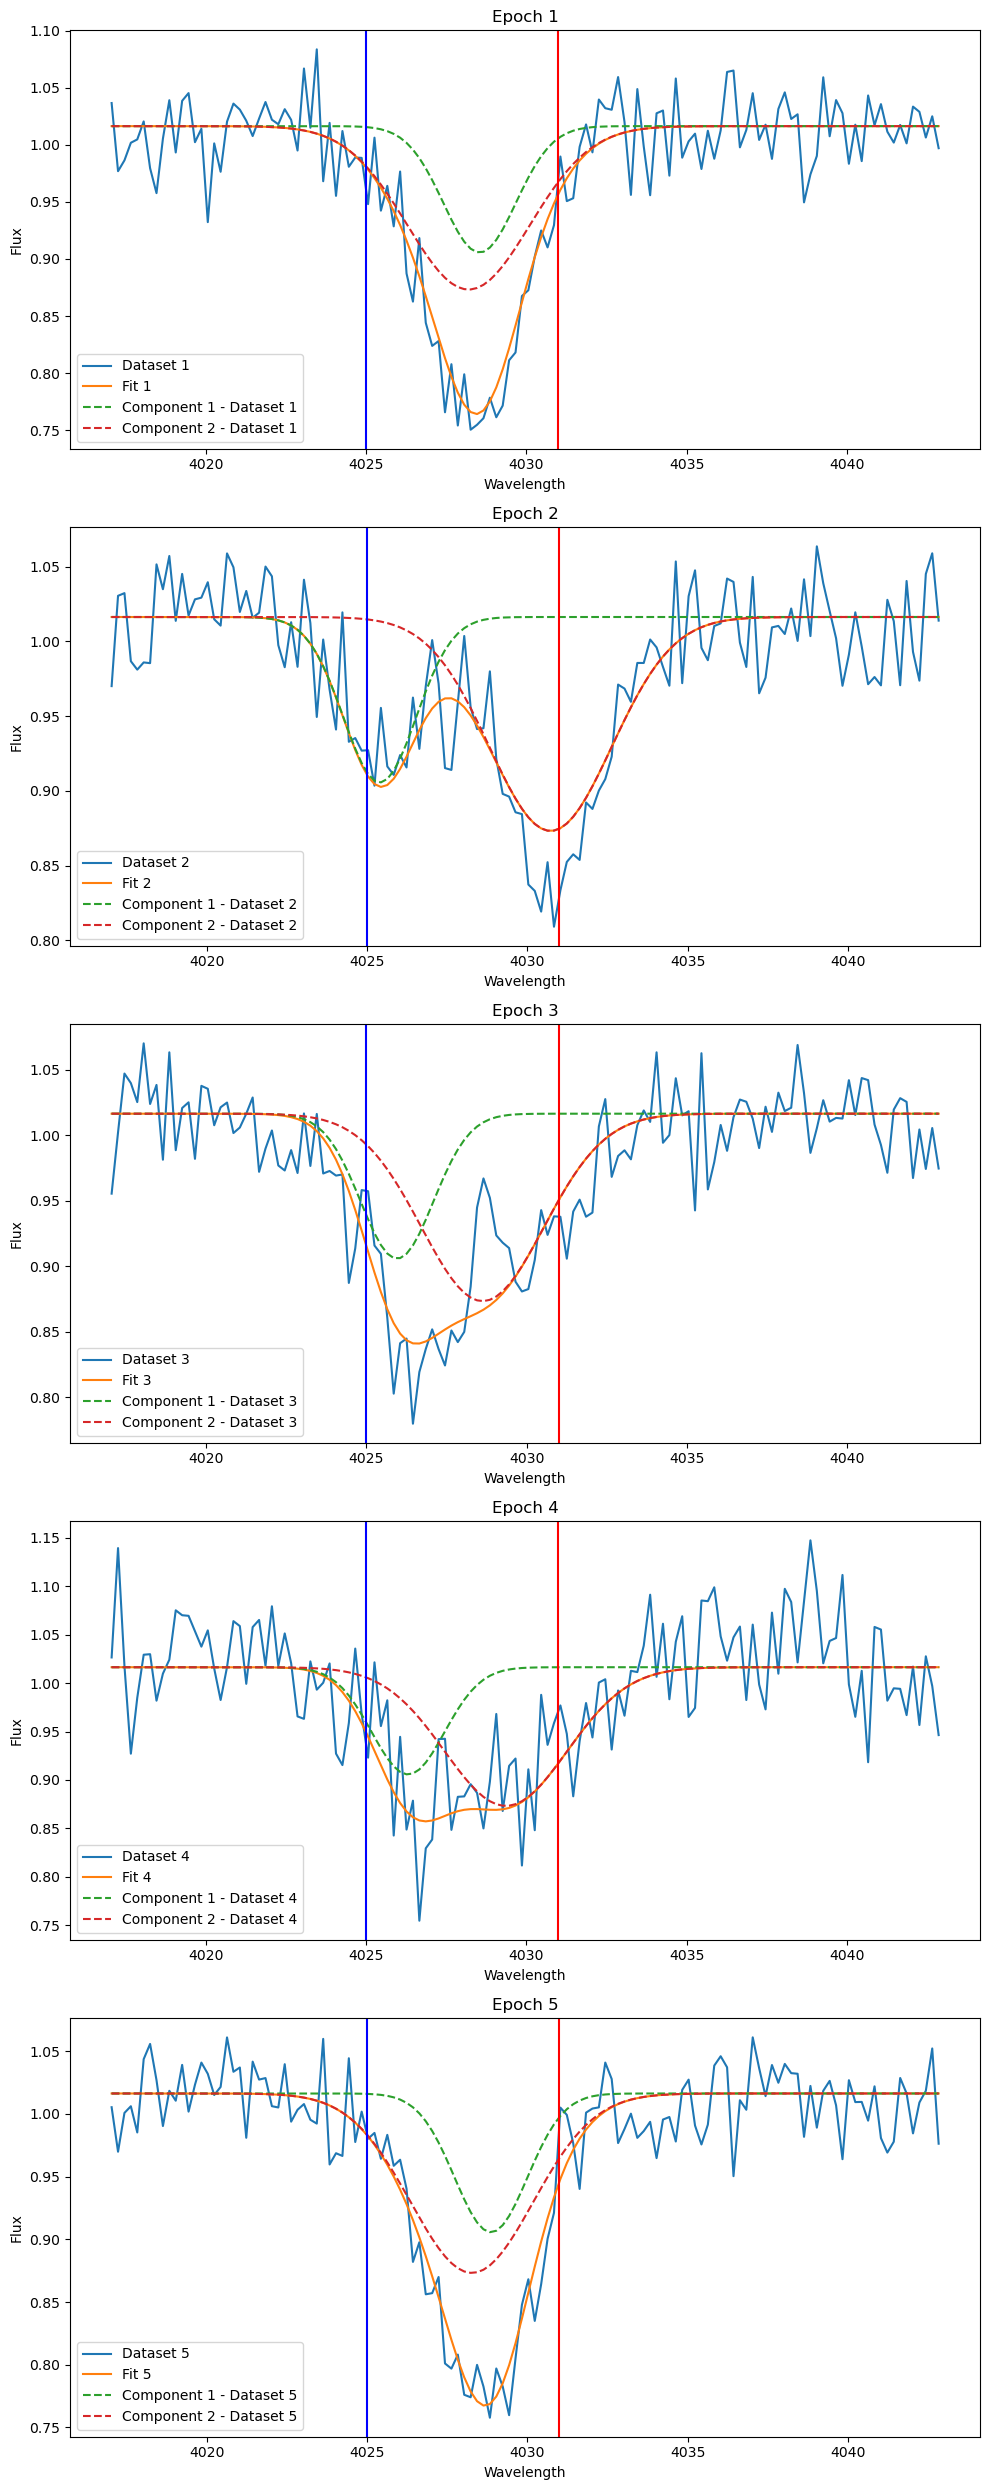

In [17]:
# Define the objective function for global optimization
def objective(params, x, data):
    resid = []
    for i, (x_vals, data_vals) in enumerate(zip(x, data)):
        cen1 = np.float64(params[f'cen1_{i+1}'].value)
        cen2 = np.float64(params[f'cen2_{i+1}'].value)
        model = double_gaussian_with_continuum(x_vals, np.float64(params['amp1'].value), cen1, np.float64(params['wid1'].value), 
                                               np.float64(params['amp2'].value), cen2, np.float64(params['wid2'].value), np.float64(params['cont'].value))
        resid.append(data_vals - model)  # Weighted residuals
    return np.concatenate(resid)  # Return the weighted residual array


# Scalar objective function for basinhopping
def scalar_objective(params, x, data):
    return np.sum(objective(params, x, data)**2)  # Sum of squares of weighted residuals


# Initialize parameters for each epoch
def initialize_params(wavelengths):
    params = Parameters()
    params.add('amp1', value=0.2, min=0.05, max=1)
    params.add('wid1', value=3.0, min=0.5, max=10.0)
    params.add('amp2', value=0.12, min=0.05, max=1)
    params.add('wid2', value=3.0, min=0.5, max=10.0)
    params.add('cont', value=1.0, min=0.9, max=1.1)

    for i in range(len(wavelengths)):
        params.add(f'cen1_{i+1}', value=4028-3, min=4015, max=4035)
        params.add(f'cen2_{i+1}', value=4028+3, min=4015, max=4035)

    return params

# Perform global optimization using Basin Hopping
def global_optimization(wavelengths, fluxes, params):
    initial_params = params_to_array(params)
    minimizer_kwargs = {"method": "L-BFGS-B", "args": (wavelengths, fluxes, params)}
    result = basinhopping(scalar_objective_wrapper, initial_params, minimizer_kwargs=minimizer_kwargs, niter=200)
    array_to_params(result.x, params)
    return params

# Perform local optimization using lmfit
def local_optimization(wavelengths, fluxes, params):
    result = minimize(objective, params, args=(wavelengths, fluxes))
    return result

# Convert lmfit Parameters to a flat array
def params_to_array(params):
    return np.array([param.value for param in params.values()], dtype=np.float64)

# Convert a flat array back to lmfit Parameters
def array_to_params(param_array, params):
    for i, (name, param) in enumerate(params.items()):
        param.set(value=np.float64(param_array[i]))

# Wrapper function for the scalar objective to use with scipy.optimize
def scalar_objective_wrapper(param_array, x, data, params):
    array_to_params(param_array, params)
    return scalar_objective(params, x, data)  # Return the scalar value

# Initialize and optimize parameters

np.random.seed(42)

params = initialize_params(wavelengths)
params = global_optimization(wavelengths, fluxes, params)
result = local_optimization(wavelengths, fluxes, params)

# Print fit results
report_fit(result)

# Plot results with subplots
fig, axes = plt.subplots(nrows=len(wavelengths), ncols=1, figsize=(10, 5*len(wavelengths)))

for i, (x_vals, data_vals) in enumerate(zip(wavelengths, fluxes)):
    ax = axes[i]
    ax.plot(x_vals, data_vals, '-', label=f'Dataset {i+1}')
    model_fit = double_gaussian_with_continuum(x_vals, result.params['amp1'].value, result.params[f'cen1_{i+1}'].value, result.params['wid1'].value, 
                                               result.params['amp2'].value, result.params[f'cen2_{i+1}'].value, result.params['wid2'].value, result.params['cont'].value)
    component1 = gaussian_component(x_vals, result.params['amp1'].value, result.params[f'cen1_{i+1}'].value, result.params['wid1'].value)
    component2 = gaussian_component(x_vals, result.params['amp2'].value, result.params[f'cen2_{i+1}'].value, result.params['wid2'].value)
    
    ax.plot(x_vals, model_fit, '-', label=f'Fit {i+1}')
    ax.plot(x_vals, component1 + result.params['cont'].value, '--', label=f'Component 1 - Dataset {i+1}')
    ax.plot(x_vals, component2 + result.params['cont'].value, '--', label=f'Component 2 - Dataset {i+1}')
    ax.axvline(4028-3, c='blue')
    ax.axvline(4028+3, c='red')
    ax.legend()
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Flux')
    ax.set_title(f'Epoch {i+1}')

plt.tight_layout()
plt.show()
plt.show()